In [1]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model_task2_full.bin"

In [2]:
#!pip install fasttext
#!pip install transformers
#import nltk
#nltk.download('punkt')

In [3]:
from ast import FloorDiv
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim import AdamW
from fasttext import load_model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report

## No clean

In [4]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_task2.csv')

In [5]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [6]:
# replace all -1 to 2 since pytorch cannot handle negative
# so, 2 now means negative polarity
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 4


0

In [7]:
print(len(sentences))
print(len(aspect_tags))
print(len(polarity_tags))

3501
3501
3501


In [8]:
print(max(map(lambda x: len(x), sentences)))

84


In [9]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, pol_tags, sent_len=85):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                if aspect_tags[sx][wx] == 0:
                    mask[sx, wx] = 1
                elif aspect_tags[sx][wx] == 1:
                    mask[sx, wx] = 0
                train_y[sx, wx] = pol_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label, num_tag):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, num_tag)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [10]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense = torch.nn.Linear(gen_emb.shape[1], num_classes)

    def forward(self, x_train):
        x_emb = self.gen_embedding(x_train)

        output, (h_n, _) = self.lstm(x_emb.float())
        out = self.dense(output)

        return out

In [11]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, polarity_tags, sent_len=85)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [12]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2800
valid samples:701


In [13]:
history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()
        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]



epoch 0
	train_loss:1.068 valid_loss:1.044
	train_acc:43.57% valid_acc:49.36%
	train_f1:0.406 valid_f1:0.456
	train_confusion_matrix:
[[   0  668  606]
 [   2 1923 1750]
 [   3  770 1010]]
	valid_confusion_matrix:
[[  0 310  31]
 [  0 752  35]
 [  0 450  53]]


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]



epoch 1
	train_loss:1.006 valid_loss:1.017
	train_acc:54.45% valid_acc:48.74%
	train_f1:0.519 valid_f1:0.456
	train_confusion_matrix:
[[   0 1256   23]
 [   0 3571   68]
 [   1 1716   92]]
	valid_confusion_matrix:
[[  0 340   1]
 [  0 786   1]
 [  0 494   9]]


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]



epoch 2
	train_loss:0.966 valid_loss:1.006
	train_acc:55.11% valid_acc:48.62%
	train_f1:0.526 valid_f1:0.455
	train_confusion_matrix:
[[   0 1269    4]
 [   0 3652    7]
 [   1 1729   44]]
	valid_confusion_matrix:
[[  0 340   1]
 [  0 785   2]
 [  0 495   8]]


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]



epoch 3
	train_loss:0.944 valid_loss:0.992
	train_acc:55.70% valid_acc:50.03%
	train_f1:0.529 valid_f1:0.461
	train_confusion_matrix:
[[   0 1253   26]
 [   0 3671   11]
 [   1 1687   74]]
	valid_confusion_matrix:
[[  0 324  17]
 [  0 779   8]
 [  0 466  37]]


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]



epoch 4
	train_loss:0.926 valid_loss:0.973
	train_acc:57.28% valid_acc:52.54%
	train_f1:0.537 valid_f1:0.474
	train_confusion_matrix:
[[   0 1150  108]
 [   0 3581   37]
 [   1 1549  234]]
	valid_confusion_matrix:
[[  0 294  47]
 [  0 768  19]
 [  0 414  89]]


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]



epoch 5
	train_loss:0.897 valid_loss:0.946
	train_acc:60.67% valid_acc:54.94%
	train_f1:0.557 valid_f1:0.485
	train_confusion_matrix:
[[   1 1001  273]
 [   0 3544  150]
 [   0 1235  556]]
	valid_confusion_matrix:
[[  0 254  87]
 [  0 737  50]
 [  0 344 159]]


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]



epoch 6
	train_loss:0.864 valid_loss:0.910
	train_acc:62.03% valid_acc:56.10%
	train_f1:0.561 valid_f1:0.494
	train_confusion_matrix:
[[   3  929  354]
 [   2 3425  209]
 [   0 1056  737]]
	valid_confusion_matrix:
[[  2 210 129]
 [  0 697  90]
 [  0 287 216]]


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]



epoch 7
	train_loss:0.822 valid_loss:0.881
	train_acc:64.34% valid_acc:58.74%
	train_f1:0.580 valid_f1:0.535
	train_confusion_matrix:
[[  17  833  435]
 [   6 3360  313]
 [   3  809  951]]
	valid_confusion_matrix:
[[ 20 181 140]
 [  0 681 106]
 [  1 245 257]]


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



epoch 8
	train_loss:0.790 valid_loss:0.866
	train_acc:66.34% valid_acc:59.90%
	train_f1:0.606 valid_f1:0.561
	train_confusion_matrix:
[[  57  743  479]
 [  11 3304  347]
 [  12  676 1108]]
	valid_confusion_matrix:
[[ 34 173 134]
 [  6 688  93]
 [  4 244 255]]


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]



epoch 9
	train_loss:0.756 valid_loss:0.839
	train_acc:67.23% valid_acc:62.29%
	train_f1:0.630 valid_f1:0.597
	train_confusion_matrix:
[[ 105  697  453]
 [  26 3327  316]
 [  31  673 1073]]
	valid_confusion_matrix:
[[ 54 146 141]
 [ 14 674  99]
 [ 10 205 288]]


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]



epoch 10
	train_loss:0.734 valid_loss:0.824
	train_acc:68.73% valid_acc:62.91%
	train_f1:0.658 valid_f1:0.615
	train_confusion_matrix:
[[ 178  595  486]
 [  47 3226  354]
 [  52  556 1190]]
	valid_confusion_matrix:
[[ 68 139 134]
 [ 15 672 100]
 [ 17 200 286]]


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]



epoch 11
	train_loss:0.712 valid_loss:0.809
	train_acc:69.74% valid_acc:64.75%
	train_f1:0.677 valid_f1:0.648
	train_confusion_matrix:
[[ 221  578  443]
 [  68 3272  301]
 [  95  534 1160]]
	valid_confusion_matrix:
[[ 94 117 130]
 [ 20 660 107]
 [ 29 172 302]]


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]



epoch 12
	train_loss:0.692 valid_loss:0.794
	train_acc:70.22% valid_acc:65.79%
	train_f1:0.685 valid_f1:0.664
	train_confusion_matrix:
[[ 260  579  447]
 [  70 3293  301]
 [ 103  506 1178]]
	valid_confusion_matrix:
[[107 105 129]
 [ 24 655 108]
 [ 42 150 311]]


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]



epoch 13
	train_loss:0.663 valid_loss:0.789
	train_acc:71.83% valid_acc:66.34%
	train_f1:0.707 valid_f1:0.672
	train_confusion_matrix:
[[ 320  532  430]
 [  94 3290  289]
 [ 127  425 1226]]
	valid_confusion_matrix:
[[112 108 121]
 [ 26 671  90]
 [ 48 156 299]]


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]



epoch 14
	train_loss:0.652 valid_loss:0.785
	train_acc:73.02% valid_acc:66.46%
	train_f1:0.726 valid_f1:0.677
	train_confusion_matrix:
[[ 402  502  382]
 [ 122 3282  266]
 [ 142  399 1222]]
	valid_confusion_matrix:
[[122 104 115]
 [ 31 661  95]
 [ 56 146 301]]


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]



epoch 15
	train_loss:0.627 valid_loss:0.777
	train_acc:73.82% valid_acc:66.89%
	train_f1:0.734 valid_f1:0.679
	train_confusion_matrix:
[[ 415  487  392]
 [ 108 3310  254]
 [ 146  378 1253]]
	valid_confusion_matrix:
[[121  83 137]
 [ 26 623 138]
 [ 46 110 347]]


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]



epoch 16
	train_loss:0.611 valid_loss:0.793
	train_acc:74.97% valid_acc:65.91%
	train_f1:0.751 valid_f1:0.668
	train_confusion_matrix:
[[ 468  428  374]
 [ 123 3276  256]
 [ 150  349 1289]]
	valid_confusion_matrix:
[[113 118 110]
 [ 32 675  80]
 [ 63 153 287]]


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]



epoch 17
	train_loss:0.600 valid_loss:0.788
	train_acc:75.26% valid_acc:65.67%
	train_f1:0.757 valid_f1:0.661
	train_confusion_matrix:
[[ 491  415  366]
 [ 128 3312  247]
 [ 159  352 1269]]
	valid_confusion_matrix:
[[108 116 117]
 [ 28 655 104]
 [ 50 145 308]]


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]



epoch 18
	train_loss:0.590 valid_loss:0.780
	train_acc:75.77% valid_acc:66.22%
	train_f1:0.759 valid_f1:0.686
	train_confusion_matrix:
[[ 490  416  362]
 [ 122 3268  249]
 [ 152  319 1309]]
	valid_confusion_matrix:
[[144  97 100]
 [ 52 655  80]
 [ 89 133 281]]


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


epoch 19
	train_loss:0.574 valid_loss:0.786
	train_acc:77.12% valid_acc:66.58%
	train_f1:0.780 valid_f1:0.688
	train_confusion_matrix:
[[ 581  362  359]
 [ 128 3324  227]
 [ 172  295 1297]]
	valid_confusion_matrix:
[[141 101  99]
 [ 49 668  70]
 [ 85 141 277]]


(0.3, 1.0)

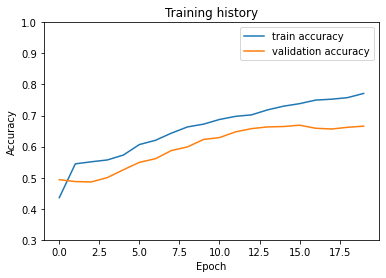

In [14]:
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.3, 1])

In [15]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []

    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)

            pred_tags = pred_logits.max(-1)[1]

            pred_tags = pred_tags[mask]
            label = label[mask]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2_full.bin


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

              precision    recall  f1-score   support

     Neutral       0.63      0.35      0.45       341
    Positive       0.76      0.79      0.78       787
    Negative       0.56      0.69      0.62       503

    accuracy                           0.67      1631
   macro avg       0.65      0.61      0.62      1631
weighted avg       0.67      0.67      0.66      1631



In [16]:
MODEL_PATH

'model_task2_full.bin'

---

In [17]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model_task2_full_clean.bin"

In [22]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_task2_cleaned.csv')

In [23]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [24]:
# replace all -1 to 2 since pytorch cannot handle negative
# so, 2 now means negative polarity
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 4


0

In [25]:
print(len(sentences))
print(len(aspect_tags))
print(len(polarity_tags))

3501
3501
3501


In [26]:
print(max(map(lambda x: len(x), sentences)))

80


In [27]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, pol_tags, sent_len=85):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                if aspect_tags[sx][wx] == 0:
                    mask[sx, wx] = 1
                elif aspect_tags[sx][wx] == 1:
                    mask[sx, wx] = 0
                train_y[sx, wx] = pol_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label, num_tag):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, num_tag)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [28]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense = torch.nn.Linear(gen_emb.shape[1], num_classes)

    def forward(self, x_train):
        x_emb = self.gen_embedding(x_train)

        output, (h_n, _) = self.lstm(x_emb.float())
        out = self.dense(output)

        return out

In [30]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, polarity_tags, sent_len=85)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [31]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2800
valid samples:701


In [32]:
history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()
        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]



epoch 0
	train_loss:1.074 valid_loss:1.048
	train_acc:43.81% valid_acc:49.34%
	train_f1:0.434 valid_f1:0.451
	train_confusion_matrix:
[[  24  730  424]
 [  58 2100 1379]
 [  24 1048  732]]
	valid_confusion_matrix:
[[  0 394  17]
 [  0 852  23]
 [  0 452  11]]


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]



epoch 1
	train_loss:1.008 valid_loss:1.014
	train_acc:54.19% valid_acc:49.86%
	train_f1:0.526 valid_f1:0.453
	train_confusion_matrix:
[[   0 1164   15]
 [   0 3489   38]
 [   0 1763   36]]
	valid_confusion_matrix:
[[  0 411   0]
 [  0 871   4]
 [  0 462   1]]


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



epoch 2
	train_loss:0.976 valid_loss:0.998
	train_acc:53.86% valid_acc:49.91%
	train_f1:0.521 valid_f1:0.453
	train_confusion_matrix:
[[   0 1186    9]
 [   0 3483    7]
 [   0 1801   23]]
	valid_confusion_matrix:
[[  0 409   2]
 [  0 871   4]
 [  0 461   2]]


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



epoch 3
	train_loss:0.951 valid_loss:0.984
	train_acc:54.99% valid_acc:51.06%
	train_f1:0.530 valid_f1:0.458
	train_confusion_matrix:
[[   0 1163   31]
 [   0 3526   23]
 [   0 1725   68]]
	valid_confusion_matrix:
[[  0 393  18]
 [  0 864  11]
 [  0 434  29]]


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]



epoch 4
	train_loss:0.931 valid_loss:0.965
	train_acc:57.54% valid_acc:53.00%
	train_f1:0.545 valid_f1:0.468
	train_confusion_matrix:
[[   0 1041  128]
 [   0 3471   63]
 [   0 1524  264]]
	valid_confusion_matrix:
[[  0 365  46]
 [  0 853  22]
 [  0 389  74]]


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



epoch 5
	train_loss:0.911 valid_loss:0.943
	train_acc:59.79% valid_acc:56.26%
	train_f1:0.556 valid_f1:0.484
	train_confusion_matrix:
[[   5  926  271]
 [   0 3386  143]
 [   0 1284  510]]
	valid_confusion_matrix:
[[  0 326  85]
 [  0 837  38]
 [  0 316 147]]


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



epoch 6
	train_loss:0.876 valid_loss:0.910
	train_acc:62.25% valid_acc:57.63%
	train_f1:0.574 valid_f1:0.493
	train_confusion_matrix:
[[  10  811  374]
 [   0 3345  218]
 [   0 1067  718]]
	valid_confusion_matrix:
[[  1 293 117]
 [  0 810  65]
 [  0 266 197]]


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



epoch 7
	train_loss:0.845 valid_loss:0.887
	train_acc:63.78% valid_acc:59.29%
	train_f1:0.587 valid_f1:0.521
	train_confusion_matrix:
[[  21  676  501]
 [   1 3216  323]
 [   0  874  945]]
	valid_confusion_matrix:
[[ 15 263 133]
 [  2 794  79]
 [  0 235 228]]


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]



epoch 8
	train_loss:0.809 valid_loss:0.864
	train_acc:65.44% valid_acc:60.03%
	train_f1:0.612 valid_f1:0.532
	train_confusion_matrix:
[[  68  649  474]
 [  11 3204  303]
 [   8  810  998]]
	valid_confusion_matrix:
[[ 22 256 133]
 [  3 782  90]
 [  1 216 246]]


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]



epoch 9
	train_loss:0.775 valid_loss:0.830
	train_acc:66.85% valid_acc:62.61%
	train_f1:0.632 valid_f1:0.571
	train_confusion_matrix:
[[ 101  593  494]
 [  20 3178  337]
 [  20  702 1088]]
	valid_confusion_matrix:
[[ 43 206 162]
 [  6 744 125]
 [  2 153 308]]


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]



epoch 10
	train_loss:0.753 valid_loss:0.812
	train_acc:68.59% valid_acc:64.09%
	train_f1:0.651 valid_f1:0.603
	train_confusion_matrix:
[[ 135  577  469]
 [  44 3145  327]
 [  40  582 1173]]
	valid_confusion_matrix:
[[ 69 195 147]
 [ 15 739 121]
 [  8 142 313]]


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]



epoch 11
	train_loss:0.732 valid_loss:0.798
	train_acc:69.45% valid_acc:64.15%
	train_f1:0.675 valid_f1:0.597
	train_confusion_matrix:
[[ 217  524  449]
 [  58 3085  339]
 [  67  541 1194]]
	valid_confusion_matrix:
[[ 63 225 123]
 [  9 770  96]
 [  9 165 289]]


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]



epoch 12
	train_loss:0.706 valid_loss:0.778
	train_acc:70.05% valid_acc:65.35%
	train_f1:0.681 valid_f1:0.627
	train_confusion_matrix:
[[ 213  515  450]
 [  66 3146  325]
 [  76  515 1194]]
	valid_confusion_matrix:
[[ 88 197 126]
 [ 14 756 105]
 [ 22 142 299]]


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]



epoch 13
	train_loss:0.687 valid_loss:0.766
	train_acc:71.29% valid_acc:65.47%
	train_f1:0.701 valid_f1:0.627
	train_confusion_matrix:
[[ 293  494  403]
 [ 102 3112  280]
 [ 115  469 1221]]
	valid_confusion_matrix:
[[ 87 208 116]
 [ 12 766  97]
 [ 28 143 292]]


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]



epoch 14
	train_loss:0.668 valid_loss:0.748
	train_acc:72.32% valid_acc:66.67%
	train_f1:0.706 valid_f1:0.655
	train_confusion_matrix:
[[ 270  462  447]
 [  82 3130  308]
 [  78  428 1317]]
	valid_confusion_matrix:
[[118 175 118]
 [ 32 747  96]
 [ 40 122 301]]


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]



epoch 15
	train_loss:0.653 valid_loss:0.752
	train_acc:73.00% valid_acc:66.55%
	train_f1:0.727 valid_f1:0.655
	train_confusion_matrix:
[[ 366  430  409]
 [ 106 3134  288]
 [ 147  388 1280]]
	valid_confusion_matrix:
[[111 189 111]
 [ 19 784  72]
 [ 41 153 269]]


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]



epoch 16
	train_loss:0.640 valid_loss:0.736
	train_acc:73.63% valid_acc:67.18%
	train_f1:0.728 valid_f1:0.666
	train_confusion_matrix:
[[ 358  428  402]
 [ 107 3115  275]
 [ 118  389 1326]]
	valid_confusion_matrix:
[[127 173 111]
 [ 33 764  78]
 [ 52 127 284]]


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



epoch 17
	train_loss:0.623 valid_loss:0.745
	train_acc:74.32% valid_acc:67.64%
	train_f1:0.747 valid_f1:0.663
	train_confusion_matrix:
[[ 440  388  380]
 [ 129 3139  252]
 [ 183  349 1286]]
	valid_confusion_matrix:
[[116 187 108]
 [ 25 784  66]
 [ 47 133 283]]


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]



epoch 18
	train_loss:0.609 valid_loss:0.730
	train_acc:74.96% valid_acc:67.81%
	train_f1:0.751 valid_f1:0.668
	train_confusion_matrix:
[[ 420  396  372]
 [ 115 3199  253]
 [ 147  355 1285]]
	valid_confusion_matrix:
[[126 173 112]
 [ 38 765  72]
 [ 53 115 295]]


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


epoch 19
	train_loss:0.601 valid_loss:0.726
	train_acc:75.30% valid_acc:68.27%
	train_f1:0.755 valid_f1:0.671
	train_confusion_matrix:
[[ 432  357  391]
 [ 128 3128  266]
 [ 162  309 1358]]
	valid_confusion_matrix:
[[125 174 112]
 [ 32 768  75]
 [ 51 111 301]]


(0.3, 1.0)

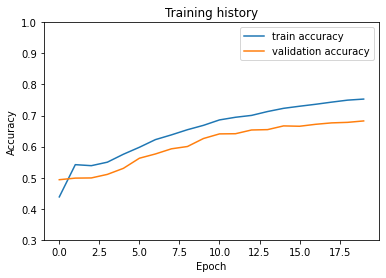

In [33]:
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.3, 1])

In [34]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []

    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)

            pred_tags = pred_logits.max(-1)[1]

            pred_tags = pred_tags[mask]
            label = label[mask]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2_full_clean.bin


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

              precision    recall  f1-score   support

     Neutral       0.60      0.30      0.40       411
    Positive       0.73      0.88      0.80       875
    Negative       0.62      0.65      0.63       463

    accuracy                           0.68      1749
   macro avg       0.65      0.61      0.61      1749
weighted avg       0.67      0.68      0.66      1749



In [35]:
MODEL_PATH

'model_task2_full_clean.bin'